In [9]:
import numpy as np
import operator

In [10]:
def build_link_matrix_A(filename, apply_patch=True):
    """
    Costruisce la Link Matrix A (o A') partendo da un file dataset .dat.
    
    Questa funzione gestisce la lettura dei dati sparsi (archi) e la creazione 
    della matrice densa o sparsa necessaria per il calcolo.
    
    Args:
        filename (str): Il percorso del file .dat (es. 'web-Stanford.dat').
        apply_patch (bool): 
            - Se True: Applica la "Patch" ai dangling nodes. Sostituisce le colonne di zeri
              con 1/N. Restituisce una matrice A' perfettamente STOCASTICA.
              (Utile se si vuole simulare il comportamento 'random surfer' puro).
            - Se False: Lascia le colonne di zeri intatte. Restituisce A SUBSTOCASTICA.
              (Questo è il metodo usato nel paper originale e richiede la normalizzazione
               finale nel calcolo del PageRank per compensare la perdita di massa).
                            
    Returns:
        tuple: (A, N)
            - A (numpy.ndarray): La matrice N x N costruita.
            - N (int): Il numero totale di nodi (pagine), utile per creare i vettori successivi.
    """
    
    links = []
    
    # =========================================================================
    # --- PARTE 1: LETTURA DEL FILE E PRE-ELABORAZIONE ---
    # =========================================================================
    try:
        with open(filename, 'r') as file:
            
            # 1. Lettura Header
            # Il file inizia con "N M" (Nodi, Archi). Ci serve N per dimensionare la matrice.
            header_line = file.readline().strip().split()
            if not header_line or len(header_line) < 2:
                raise ValueError("Il file deve iniziare con una riga 'N M' valida.")
            
            num_nodes = int(header_line[0])
            N = num_nodes  # Dimensione della matrice quadrata (N x N)
            
            # 2. Salta le righe di mappatura URL
            # Le prime N righe dopo l'header sono URL (stringhe). 
            # Per la matematica servono solo gli ID numerici, quindi le saltiamo.
            print(f"Saltando le prime {num_nodes} righe di mappatura URL...")
            for _ in range(num_nodes):
                file.readline()
            
            # 3. Processa gli archi (Link)
            # Dizionario per contare quanti link escono da ogni pagina (Out-Degree, n_j).
            # Serve per calcolare la probabilità di transizione (1 / n_j).
            out_degree = {} 
            valid_link_count = 0
            
            for line in file:
                parts = line.strip().split()
                # Ci aspettiamo righe fatte da "Source_ID Target_ID"
                if len(parts) == 2:
                    try:
                        source_id = int(parts[0])
                        target_id = int(parts[1])
                        
                        # Contiamo l'out-degree per il nodo sorgente
                        out_degree[source_id] = out_degree.get(source_id, 0) + 1
                        
                        # Memorizziamo l'arco per dopo
                        links.append((source_id, target_id))
                        valid_link_count += 1
                    except ValueError:
                        # Gestione robusta per righe malformate
                        continue
                        
            print(f"Letti {valid_link_count} archi validi.")

    except Exception as e:
        print(f"Errore durante l'elaborazione del file: {e}")
        return None, 0

    if N == 0:
        return None, 0

    # =========================================================================
    # --- PARTE 2: COSTRUZIONE BASE DI A (La Matrice dei Link) ---
    # =========================================================================
    
    # Creiamo una matrice N x N piena di zeri.
    A = np.zeros((N, N))

    # Popoliamo la matrice usando gli archi letti.
    # Regola: A[i, j] = 1 / n_j  (dove j=sorgente, i=destinazione)
    for source_id, target_id in links:
        # Convertiamo da ID (base-1, dal file) a Indice (base-0, per Python)
        source_idx = source_id - 1  # Colonna j
        target_idx = target_id - 1  # Riga i
        
        # Recuperiamo n_j (quanti link escono dalla sorgente)
        n_j = out_degree.get(source_id, 0)
        
        # Controllo di sicurezza sugli indici e divisione per zero
        if 0 <= source_idx < N and 0 <= target_idx < N and n_j > 0:
            A[target_idx, source_idx] = 1.0 / n_j

    # A questo punto, se un nodo non ha link in uscita (dangling), 
    # la sua colonna è interamente di ZERI. (Matrice Substocastica).

    # =========================================================================
    # --- PARTE 3: APPLICAZIONE DELLA PATCH (Opzionale) ---
    # =========================================================================
    if apply_patch:
        print("Applicazione della PATCH ai dangling nodes (Trasformazione A -> A')...")
        dangling_count = 0
        
        # Valore da inserire: probabilità uniforme distribuita su N nodi
        patch_value = 1.0 / N
        
        # Scansioniamo tutte le colonne (nodi sorgente)
        for j in range(N):
            # Verifichiamo se è un Dangling Node (out_degree = 0)
            # Nota: usiamo j+1 perché le chiavi del dizionario sono ID base-1
            if out_degree.get(j + 1, 0) == 0:
                
                # LA FIX: Sostituiamo la colonna di zeri con 1/N.
                # Fisicamente significa: "Se arrivi qui, salti a una pagina a caso".
                A[:, j] = patch_value
                dangling_count += 1
                
        print(f"Patch applicata a {dangling_count} dangling nodes su {N} totali.")
        print("La matrice risultante è ora perfettamente column-stocastica (somma colonne = 1).")
    else:
        print("Nessuna patch applicata.")
        print("La matrice rimane substocastica (le colonne dei dangling nodes sommano a 0).")
        print("NOTA: L'algoritmo PageRank dovrà usare la normalizzazione finale per funzionare.")

    print(f"Matrice Link {N}x{N} pronta per il calcolo.")
    return A, N

In [11]:
def calculate_pagerank(L_matrix, m=0.15, max_iter=200, tolerance=1e-7):
    """
    Calcola il PageRank utilizzando il Power Method (Iterazione della Potenza).
    
    Questa funzione implementa la formula iterativa:
    x(k+1) = (1 - m) * A * x(k) + m * s
    
    Args:
        L_matrix (numpy.ndarray): La Link Matrix A (N x N). Può essere substocastica (dangling nodes).
        m (float): Probabilità di teletrasporto (es. 0.15). (1-m) è il Damping Factor (0.85).
        max_iter (int): Numero massimo di iterazioni per evitare loop infiniti.
        tolerance (float): Soglia di convergenza. Se la differenza tra due iterazioni è minore di questo, ci fermiamo.
        
    Returns:
        tuple: (autovettore_PageRank, numero_iterazioni)
    """
    
    # 1. Determina la dimensione del Web (N)
    # L_matrix.shape[0] restituisce il numero di righe (nodi).
    n = L_matrix.shape[0]
    
    # 2. Crea il vettore di Teletrasporto (s)
    # È un vettore colonna dove ogni elemento è 1/N.
    # Rappresenta la probabilità uniforme che l'utente atterri su una pagina a caso.
    s = np.full((n, 1), 1/n)
    
    # 3. Inizializzazione del vettore PageRank (x)
    # All'inizio (t=0), assumiamo che tutte le pagine abbiano la stessa importanza (1/N).
    x = np.full((n, 1), 1/n)
    
    # Variabile per contare le iterazioni effettive
    k = 0
    
    # --- INIZIO POWER METHOD ---
    for k in range(max_iter):
        
        # Salviamo il vettore dell'iterazione precedente per confrontarlo dopo
        x_prev = x.copy()
        
        # --- PASSO A: Navigazione tramite Link ---
        # Calcoliamo A * x. 
        # Qui la probabilità fluisce attraverso i link esistenti.
        # Nota: L_matrix è sparsa (ha molti zeri), quindi questa operazione è veloce.
        Ax = L_matrix @ x_prev
        
        # --- PASSO B: Applicazione della formula Google (Implicit M) ---
        # Formula: x_new = (1-m) * (Link) + m * (Teletrasporto)
        # (1 - m) * Ax : La probabilità che segue i link (es. 85%)
        # m * s        : La probabilità che viene ridistribuita ovunque (es. 15%)
        # Questo passaggio simula la moltiplicazione per la matrice M senza doverla costruire.
        x = (1 - m) * Ax + m * s
        
        # --- PASSO C: Verifica della Convergenza ---
        # Calcoliamo la Norma L1 della differenza (la somma dei valori assoluti delle differenze).
        # Se il vettore è cambiato pochissimo rispetto al giro prima, abbiamo trovato l'equilibrio.
        diff = np.sum(np.abs(x - x_prev))
        
        if diff < tolerance:
            # Usciamo dal ciclo for anticipatamente se abbiamo convergenza
            break
            
    # --- FINE POWER METHOD ---

    # 4. Normalizzazione Finale (Cruciale per i Dangling Nodes)
    # Se L_matrix non aveva la patch (aveva colonne di zeri), abbiamo perso un po' di probabilità
    # a ogni giro (la somma di x sarà < 1, es. 0.85).
    # Questa divisione riporta la somma esattamente a 1.0, mantenendo le proporzioni corrette.
    x_normalized = x / np.sum(x)
    
    # Restituisce l'autovettore finale (normalizzato) e il numero di iterazioni impiegate (k+1 perché k parte da 0)
    return x_normalized, k + 1

In [12]:
# --- Esempio 1: Web a 4 pagine (Figura 2.1) ---
print("=============================================")
print("  ESECUZIONE: WEB A 4 PAGINE (FIGURA 2.1) ")
print("=============================================")

A_4pages = np.array([
    [0.0, 0.0, 1.0, 0.5],
    [1/3, 0.0, 0.0, 0.0],
    [1/3, 0.5, 0.0, 0.5],
    [1/3, 0.5, 0.0, 0.0]
])

pagerank_scores_4pages,iterations_4pages = calculate_pagerank(A_4pages, m=0.15)

# Preparazione dei risultati: lista di tuple (ID pagina, Punteggio)
page_indices_4pages = np.arange(1, A_4pages.shape[0] + 1)
results_4pages = list(zip(page_indices_4pages, pagerank_scores_4pages.flatten()))
results_4pages_sorted = sorted(results_4pages, key=operator.itemgetter(1), reverse=True)

for page_id, score in results_4pages_sorted:
    print(f"Pagina {page_id}: {score:.4f}")
    
print(f"Calcolo completato in {iterations_4pages} iterazioni.")

# --- Esempio 2: Web a 5 pagine (Figura 2.2) ---
print("\n\n=============================================")
print("  ESECUZIONE: WEB A 5 PAGINE (FIGURA 2.2) ")
print("=============================================")


A_5pages = np.array([
    [0.0, 1.0, 0.0, 0.0, 0.0],   # Links TO page 1 (from 2)
    [1.0, 0.0, 0.0, 0.0, 0.0],   # Links TO page 2 (from 1)
    [0.0, 0.0, 0.0, 1.0, 0.5],   # Links TO page 3 (from 4, 5)
    [0.0, 0.0, 1.0, 0.0, 0.5],   # Links TO page 4 (from 3, 5)
    [0.0, 0.0, 0.0, 0.0, 0.0]    # Links TO page 5 (none)
])

# Calcolo del PageRank
pagerank_scores_5pages,iterations_5pages = calculate_pagerank(A_5pages, m=0.15)

# Preparazione dei risultati: lista di tuple (ID pagina, Punteggio)
page_indices_5pages = np.arange(1, A_5pages.shape[0] + 1)
results_5pages = list(zip(page_indices_5pages, pagerank_scores_5pages.flatten()))
results_5pages_sorted = sorted(results_5pages, key=operator.itemgetter(1), reverse=True)


for page_id, score in results_5pages_sorted:
    print(f"Pagina {page_id}: {score:.4f}")
    
print(f"Calcolo completato in {iterations_5pages} iterazioni.")


  ESECUZIONE: WEB A 4 PAGINE (FIGURA 2.1) 
Pagina 1: 0.3682
Pagina 3: 0.2880
Pagina 4: 0.2021
Pagina 2: 0.1418
Calcolo completato in 21 iterazioni.


  ESECUZIONE: WEB A 5 PAGINE (FIGURA 2.2) 
Pagina 3: 0.2850
Pagina 4: 0.2850
Pagina 1: 0.2000
Pagina 2: 0.2000
Pagina 5: 0.0300
Calcolo completato in 2 iterazioni.


In [13]:
#Calcolo del pagerank sul dataset hollins.dat

filename = 'hollins.dat'
m=0.15 
top_k=10

# 1. COSTRUZIONE DELLA MATRICE A 
# Versione senza patch: A_matrix, N_nodes = build_link_matrix_A(filename)

A_matrix, N_nodes = build_link_matrix_A(filename)

# 2. CALCOLO DEL PAGERANK
print("\nInizio Calcolo PageRank (Iterazione della Potenza)...")
pagerank_scores, iterations = calculate_pagerank(A_matrix, m=m)

print(f"Calcolo completato in {iterations} iterazioni.")

# 3. PREPARAZIONE E STAMPA DEI RISULTATI
page_ids = np.arange(1, N_nodes + 1)
results = list(zip(page_ids, pagerank_scores.flatten()))

# Ordinamento per punteggio in ordine decrescente
results_sorted = sorted(results, key=operator.itemgetter(1), reverse=True)

print(f"\n--- Classifica TOP {top_k} Pagine (su {N_nodes} totali) ---")

# Stampa i primi K risultati
for rank, (page_id, score) in enumerate(results_sorted[:top_k], 1):
    # NOTA: Per un progetto reale, qui dovresti ricercare l'URL
    # corrispondente all'ID della pagina dalla sezione 1 del file.
    print(f"Rank {rank}: Pagina ID {page_id} (Score: {score:.6f})")

print("-------------------------------------------------------")

# INFORMAZIONI AGGIUNTIVE (Utile per la relazione)
# Per una buona valutazione, potresti stampare l'importanza del nodo meno importante
# che dovrebbe avvicinarsi al punteggio minimo teorico (m/N).
min_score = results_sorted[-1][1]
expected_min = m / N_nodes
print(f"Punteggio minimo (ultima pagina): {min_score:.6f}")
print(f"Punteggio teorico minimo ({m}/N): {expected_min:.6f}")
    


Saltando le prime 6012 righe di mappatura URL...
Letti 23875 archi validi.
Applicazione della PATCH ai dangling nodes (Trasformazione A -> A')...
Patch applicata a 3189 dangling nodes su 6012 totali.
La matrice risultante è ora perfettamente column-stocastica (somma colonne = 1).
Matrice Link 6012x6012 pronta per il calcolo.

Inizio Calcolo PageRank (Iterazione della Potenza)...
Calcolo completato in 71 iterazioni.

--- Classifica TOP 10 Pagine (su 6012 totali) ---
Rank 1: Pagina ID 2 (Score: 0.019879)
Rank 2: Pagina ID 37 (Score: 0.009288)
Rank 3: Pagina ID 38 (Score: 0.008610)
Rank 4: Pagina ID 61 (Score: 0.008065)
Rank 5: Pagina ID 52 (Score: 0.008027)
Rank 6: Pagina ID 43 (Score: 0.007165)
Rank 7: Pagina ID 425 (Score: 0.006583)
Rank 8: Pagina ID 27 (Score: 0.005989)
Rank 9: Pagina ID 28 (Score: 0.005572)
Rank 10: Pagina ID 4023 (Score: 0.004452)
-------------------------------------------------------
Punteggio minimo (ultima pagina): 0.000058
Punteggio teorico minimo (0.15/N): 0.0

In [14]:
import numpy as np
import operator

# Impostare m = 0.0 nella funzione calculate_pagerank equivale matematicamente ad usare la "formula (2.1)" del pdf,
#ovvero il calcolo del ranking basato sulla pura matrice di link A senza alcun teletrasporto.

print("=============================================")
print(" ESERCIZIO 1: MANIPOLAZIONE DEL PAGERANK (SENZA TELETRASPORTO)")
print(" (Utilizzo Matrice A pura, ovvero m=0.0)")
print("=============================================")

# ---------------------------------------------------------
# 1. Situazione Originale (4 Pagine)
# ---------------------------------------------------------
print("\n--- 1. Situazione Originale (4 Pagine) ---")

A_orig = np.array([
    [0.0, 0.0, 1.0, 0.5],  
    [1/3, 0.0, 0.0, 0.0],  
    [1/3, 0.5, 0.0, 0.5],  
    [1/3, 0.5, 0.0, 0.0]   
])

#m=0.0 per usare la formula (2.1) Ax = x
scores_orig, iters_orig = calculate_pagerank(A_orig, m=0.0, max_iter=1000)

# Stampa Risultati Originali
indices_orig = np.arange(1, A_orig.shape[0] + 1)
results_orig = list(zip(indices_orig, scores_orig.flatten()))
results_orig_sorted = sorted(results_orig, key=operator.itemgetter(1), reverse=True)

print("Classifica Originale (m=0):")
for page_id, score in results_orig_sorted:
    print(f"Pagina {page_id}: {score:.4f}")

p1_score_orig = scores_orig[0][0]
p3_score_orig = scores_orig[2][0]


# ---------------------------------------------------------
# 2. Situazione Modificata (5 Pagine)
# ---------------------------------------------------------
print("\n--- 2. Situazione Modificata (5 Pagine) ---")
print("Modifica: Aggiunta Pagina 5. Link: 3->5 e 5->3.")

# Matrice A Modificata (5x5)
A_mod = np.array([
    [0.0, 0.0, 0.5, 0.5, 0.0],  
    [1/3, 0.0, 0.0, 0.0, 0.0],  
    [1/3, 0.5, 0.0, 0.5, 1.0],  
    [1/3, 0.5, 0.0, 0.0, 0.0],  
    [0.0, 0.0, 0.5, 0.0, 0.0]   
])

# CORREZIONE QUI: m=0.0. Senza il fattore di smorzamento,
# la "trappola" 3-5 dovrebbe assorbire tutto il rank.
scores_mod, iters_mod = calculate_pagerank(A_mod, m=0.0, max_iter=1000)

# Stampa Risultati Modificati
indices_mod = np.arange(1, A_mod.shape[0] + 1)
results_mod = list(zip(indices_mod, scores_mod.flatten()))
results_mod_sorted = sorted(results_mod, key=operator.itemgetter(1), reverse=True)

print(f"Calcolo completato in {iters_mod} iterazioni.")
print("Classifica Modificata (m=0):")
for page_id, score in results_mod_sorted:
    print(f"Pagina {page_id}: {score:.4f}")

p1_score_mod = scores_mod[0][0]
p3_score_mod = scores_mod[2][0]

# ---------------------------------------------------------
# VERIFICA FINALE
# ---------------------------------------------------------
print("\n=============================================")
print(" VERIFICA RISULTATI (Con m=0.0)")
print("=============================================")
print(f"PRIMA: Pagina 1 ({p1_score_orig:.4f}) vs Pagina 3 ({p3_score_orig:.4f})")
print(f"DOPO:  Pagina 1 ({p1_score_mod:.4f}) vs Pagina 3 ({p3_score_mod:.4f})")

if p3_score_mod > p1_score_mod:
    print("\nRISPOSTA: SÌ. La strategia ha funzionato.")
    print("Senza damping factor (m=0), la Pagina 3 e 5 formano una 'Rank Sink'")
    print("e accumulano tutta l'importanza del web.")
else:
    print("\nRISPOSTA: NO.")

 ESERCIZIO 1: MANIPOLAZIONE DEL PAGERANK (SENZA TELETRASPORTO)
 (Utilizzo Matrice A pura, ovvero m=0.0)

--- 1. Situazione Originale (4 Pagine) ---
Classifica Originale (m=0):
Pagina 1: 0.3871
Pagina 3: 0.2903
Pagina 4: 0.1935
Pagina 2: 0.1290

--- 2. Situazione Modificata (5 Pagine) ---
Modifica: Aggiunta Pagina 5. Link: 3->5 e 5->3.
Calcolo completato in 49 iterazioni.
Classifica Modificata (m=0):
Pagina 3: 0.3673
Pagina 1: 0.2449
Pagina 5: 0.1837
Pagina 4: 0.1224
Pagina 2: 0.0816

 VERIFICA RISULTATI (Con m=0.0)
PRIMA: Pagina 1 (0.3871) vs Pagina 3 (0.2903)
DOPO:  Pagina 1 (0.2449) vs Pagina 3 (0.3673)

RISPOSTA: SÌ. La strategia ha funzionato.
Senza damping factor (m=0), la Pagina 3 e 5 formano una 'Rank Sink'
e accumulano tutta l'importanza del web.


In [15]:
print("=============================================")
print(" ESERCIZIO 11: CALCOLO PAGERANK SU RETE MODIFICATA")
print(" (Autovettore di M con m=0.15)")
print("=============================================")

# ---------------------------------------------------------
# DEFINIZIONE DEL WEB (5 PAGINE)
# ---------------------------------------------------------
# Specifica dell'esercizio:
# - Base: Figura 2.1 (4 pagine)
# - Aggiunta: Pagina 5
# - Link: 5 -> 3
# - Link: 3 -> 5 (oltre ai suoi link originali)

A_ex11 = np.array([
    [0.0, 0.0, 0.5, 0.5, 0.0],  
    [1/3, 0.0, 0.0, 0.0, 0.0],  
    [1/3, 0.5, 0.0, 0.5, 1.0],  
    [1/3, 0.5, 0.0, 0.0, 0.0],  
    [0.0, 0.0, 0.5, 0.0, 0.0]   
])

# ---------------------------------------------------------
# CALCOLO (Trovare l'autovettore di M)
# ---------------------------------------------------------
# L'esercizio chiede di usare m = 0.15 [cite: 282]
# La nostra funzione calculate_pagerank risolve esattamente x = Mx
scores_ex11, iters_ex11 = calculate_pagerank(A_ex11, m=0.15)

# ---------------------------------------------------------
# VISUALIZZAZIONE RISULTATI
# ---------------------------------------------------------
print(f"\nCalcolo convergenze in {iters_ex11} iterazioni.")
print("Ranking Finale (Autovettore Normalizzato):")

indices_ex11 = np.arange(1, 6) # Pagine da 1 a 5
results_ex11 = list(zip(indices_ex11, scores_ex11.flatten()))
results_ex11_sorted = sorted(results_ex11, key=operator.itemgetter(1), reverse=True)

for page_id, score in results_ex11_sorted:
    print(f"Pagina {page_id}: {score:.4f}")

# Verifica specifica richiesta implicitamente dal confronto con l'Ex 1
p1 = scores_ex11[0][0]
p3 = scores_ex11[2][0]
print(f"\nConfronto Chiave:")
print(f"Pagina 3 ({p3:.4f}) > Pagina 1 ({p1:.4f})?")
print("SÌ" if p3 > p1 else "NO")

 ESERCIZIO 11: CALCOLO PAGERANK SU RETE MODIFICATA
 (Autovettore di M con m=0.15)

Calcolo convergenze in 33 iterazioni.
Ranking Finale (Autovettore Normalizzato):
Pagina 3: 0.3489
Pagina 1: 0.2371
Pagina 5: 0.1783
Pagina 4: 0.1385
Pagina 2: 0.0972

Confronto Chiave:
Pagina 3 (0.3489) > Pagina 1 (0.2371)?
SÌ


In [16]:
print("=============================================")
print(" ESERCIZIO 12: PAGINA SENZA BACKLINKS (Matrice Diretta)")
print("=============================================")

A_ex12 = np.array([
    [0.0, 0.0, 0.5, 0.5, 0.0, 0.2], 
    [1/3, 0.0, 0.0, 0.0, 0.0, 0.2], 
    [1/3, 0.5, 0.0, 0.5, 1.0, 0.2], 
    [1/3, 0.5, 0.0, 0.0, 0.0, 0.2], 
    [0.0, 0.0, 0.5, 0.0, 0.0, 0.2], 
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # Riga Pg 6 (Nessuno linka a lei -> Backlinks = 0)
])

# ---------------------------------------------------------
# CALCOLO 1: USANDO SOLO A (m=0.0)
# ---------------------------------------------------------
print("\n--- CASO A: Ranking con m=0.0 (Solo Link) ---")
scores_A, iters_A = calculate_pagerank(A_ex12, m=0.0, max_iter=1000)

results_A = list(zip(np.arange(1, 7), scores_A.flatten()))
results_A_sorted = sorted(results_A, key=operator.itemgetter(1), reverse=True)

for page_id, score in results_A_sorted:
    print(f"Pagina {page_id}: {score:.4f}")

# ---------------------------------------------------------
# CALCOLO 2: USANDO M (m=0.15)
# ---------------------------------------------------------
print("\n--- CASO B: Ranking con m=0.15 (Modello Google) ---")
scores_M, iters_M = calculate_pagerank(A_ex12, m=0.15)

results_M = list(zip(np.arange(1, 7), scores_M.flatten()))
results_M_sorted = sorted(results_M, key=operator.itemgetter(1), reverse=True)

for page_id, score in results_M_sorted:
    print(f"Pagina {page_id}: {score:.4f}")

# ---------------------------------------------------------
# VERIFICA PAGINA 6
# ---------------------------------------------------------
print("\nVerifica Pagina 6 (Nessun Backlink):")
print(f"Con m=0.00 -> Score: {scores_A[5][0]:.6f} (Dovrebbe essere 0)")
print(f"Con m=0.15 -> Score: {scores_M[5][0]:.6f} (Minimo garantito = 0.15/6 = 0.025)")

 ESERCIZIO 12: PAGINA SENZA BACKLINKS (Matrice Diretta)

--- CASO A: Ranking con m=0.0 (Solo Link) ---
Pagina 3: 0.3673
Pagina 1: 0.2449
Pagina 5: 0.1837
Pagina 4: 0.1224
Pagina 2: 0.0816
Pagina 6: 0.0000

--- CASO B: Ranking con m=0.15 (Modello Google) ---
Pagina 3: 0.3402
Pagina 1: 0.2312
Pagina 5: 0.1738
Pagina 4: 0.1350
Pagina 2: 0.0948
Pagina 6: 0.0250

Verifica Pagina 6 (Nessun Backlink):
Con m=0.00 -> Score: 0.000000 (Dovrebbe essere 0)
Con m=0.15 -> Score: 0.025000 (Minimo garantito = 0.15/6 = 0.025)


In [17]:
print("=============================================")
print(" ESERCIZIO 13: SOTTORETI DISCONNESSE")
print("=============================================")

# ---------------------------------------------------------
# COSTRUZIONE DELLA MATRICE (5 PAGINE, 2 SOTTORETI)
# ---------------------------------------------------------

# (Nessun link tra il gruppo {1,2} e il gruppo {3,4,5})

A_ex13 = np.array([
    [0.0, 1.0,   0.0, 0.0, 0.0], 
    [1.0, 0.0,   0.0, 0.0, 0.0], 
    
    [0.0, 0.0,   0.0, 1.0, 1.0], 
    [0.0, 0.0,   0.5, 0.0, 0.0], 
    [0.0, 0.0,   0.5, 0.0, 0.0]  
])

print("Matrice A (5x5) costruita con due componenti disconnesse.")
print("Gruppo A: Pagine 1-2")
print("Gruppo B: Pagine 3-4-5")

# ---------------------------------------------------------
# CALCOLO CON FORMULA 3.1 (m=0.15)
# ---------------------------------------------------------

# Il teletrasporto permette di saltare da un'isola all'altra.

print("\n--- Calcolo Ranking (m=0.15) ---")
scores_13, iters_13 = calculate_pagerank(A_ex13, m=0.15)

results_13 = list(zip(np.arange(1, 6), scores_13.flatten()))
results_13_sorted = sorted(results_13, key=operator.itemgetter(1), reverse=True)

for page_id, score in results_13_sorted:
    group = "Gruppo A" if page_id <= 2 else "Gruppo B"
    print(f"Pagina {page_id} ({group}): {score:.4f}")

# ---------------------------------------------------------
# ANALISI DELLA SOMMA PER GRUPPI
# ---------------------------------------------------------
sum_group_A = np.sum(scores_13[0:2])
sum_group_B = np.sum(scores_13[2:5])

print("\n--- Analisi Distribuzione Probabilità ---")
print(f"Probabilità Totale Gruppo A (2 pagine): {sum_group_A:.4f}")
print(f"Probabilità Totale Gruppo B (3 pagine): {sum_group_B:.4f}")
print(f"Rapporto atteso approssimativo (2/5 vs 3/5):")
print(f"A: {2/5:.4f}, B: {3/5:.4f}")

 ESERCIZIO 13: SOTTORETI DISCONNESSE
Matrice A (5x5) costruita con due componenti disconnesse.
Gruppo A: Pagine 1-2
Gruppo B: Pagine 3-4-5

--- Calcolo Ranking (m=0.15) ---
Pagina 3 (Gruppo B): 0.2919
Pagina 1 (Gruppo A): 0.2000
Pagina 2 (Gruppo A): 0.2000
Pagina 4 (Gruppo B): 0.1541
Pagina 5 (Gruppo B): 0.1541

--- Analisi Distribuzione Probabilità ---
Probabilità Totale Gruppo A (2 pagine): 0.4000
Probabilità Totale Gruppo B (3 pagine): 0.6000
Rapporto atteso approssimativo (2/5 vs 3/5):
A: 0.4000, B: 0.6000


In [ ]:
# 1. COSTRUZIONE DELLA GOOGLE MATRIX M (Formula 3.1 del paper)
# Matrice di adiacenza normalizzata A (Esercizio 11)
A = np.array([
    [0.0, 0.0, 0.5, 0.5, 0.0], 
    [1/3, 0.0, 0.0, 0.0, 0.0], 
    [1/3, 0.5, 0.0, 0.5, 1.0], 
    [1/3, 0.5, 0.0, 0.0, 0.0], 
    [0.0, 0.0, 0.5, 0.0, 0.0]  
])

# Parametri del paper
m = 0.15          # Probabilità di teletrasporto
N = 5             # Dimensione del web
S = np.full((N, N), 1/N) # Matrice di teletrasporto uniforme

# Formula (3.1): M = (1-m)A + mS
M = (1 - m) * A + m * S

# 2. CALCOLO DELLO STATO STAZIONARIO ESATTO (q)
# Calcolato tramite autovettori per avere il riferimento per l'errore
eigenvalues, eigenvectors = np.linalg.eig(M)
idx_q = np.argmin(np.abs(eigenvalues - 1.0))
q = np.real(eigenvectors[:, idx_q])
q = q / np.sum(q) # Normalizzazione (Somma = 1)
q = q.reshape(-1, 1)

# 3. APPLICAZIONE DEL POWER METHOD (x_k = M * x_k-1)
# Vettore di probabilità iniziale x0 (Tutta la massa sulla Pagina 1)
x = np.array([[1.0], [0.0], [0.0], [0.0], [0.0]])

print(f"{'Iter (k)':<10} | {'Errore L1 (e_k)':<20} | {'Rapporto (e_k/e_k-1)':<20}")
print("-" * 60)

prev_error = np.sum(np.abs(x - q))

for k in range(1, 51):
    x = M @ x  # Passo iterativo del Random Surfer
    curr_error = np.sum(np.abs(x - q))
    ratio = curr_error / prev_error
    
    # Stampiamo i checkpoint richiesti dal paper
    if k in [1, 5, 10, 50]:
        print(f"{k:<10} | {curr_error:<20.10f} | {ratio:<20.10f}")
    
    prev_error = curr_error

# 4. CALCOLO DEI PARAMETRI TEORICI DEL PAPER
# Coefficiente di Ergodicità c(M)
# Formula: max_j | 1 - 2 * min_i M_ij |
min_entries_per_column = np.min(M, axis=0)
c_M = np.max(np.abs(1 - 2 * min_entries_per_column))

# Secondo Autovalore dominante |lambda_2|
abs_eigenvalues = np.sort(np.abs(eigenvalues))[::-1]
lambda_2 = abs_eigenvalues[1]

print("-" * 60)
print(f"RISULTATI TEORICI:")
print(f"Secondo autovalore |lambda_2|:   {lambda_2:.6f}")
print(f"Coefficiente Ergodicità c(M):  {c_M:.6f}")
print(f"\nVerifica Proposizione 4: |lambda_2| <= c(M) è {lambda_2 <= c_M}")
print(f"Verifica Convergenza: Il rapporto finale ({ratio:.4f}) tende a |lambda_2| ({lambda_2:.4f})")

Secondo autovalore effettivio: 0.6113
Limite teorico (1-m): 0.8500


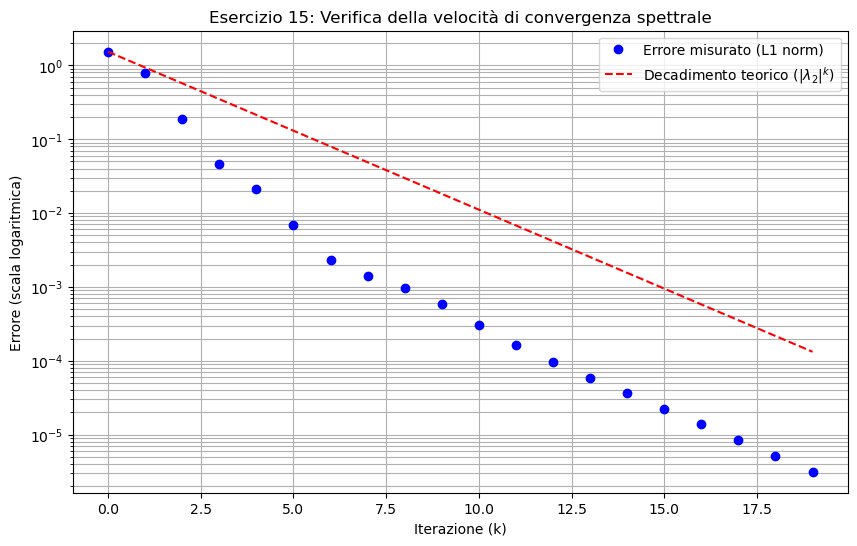

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 1. SETUP (Stessa matrice dell'esercizio precedente)
A = np.array([
    [0.0, 0.0, 0.5, 0.5, 0.0], 
    [1/3, 0.0, 0.0, 0.0, 0.0], 
    [1/3, 0.5, 0.0, 0.5, 1.0], 
    [1/3, 0.5, 0.0, 0.0, 0.0], 
    [0.0, 0.0, 0.5, 0.0, 0.0]  
])
m = 0.15
N = 5
M = (1 - m) * A + m * np.full((N, N), 1/N)

# 2. CALCOLO AUTOVALORI E STATO STAZIONARIO
eigenvalues, eigenvectors = np.linalg.eig(M)

# Ordiniamo gli autovalori per magnitudo
abs_ev = np.sort(np.abs(eigenvalues))[::-1]
lambda_1 = abs_ev[0] # Dovrebbe essere 1.0
lambda_2 = abs_ev[1] # Il secondo autovalore

# q è l'autovettore corrispondente a lambda_1
idx_q = np.argmin(np.abs(eigenvalues - 1.0))
q = np.real(eigenvectors[:, idx_q])
q = (q / np.sum(q)).reshape(-1, 1)

# 3. SIMULAZIONE POWER METHOD E RACCOLTA ERRORI
x = np.array([[1.0], [0.0], [0.0], [0.0], [0.0]])
errors = []
theoretical_decay = []

steps = range(20)
initial_error = np.sum(np.abs(x - q))

for k in steps:
    curr_error = np.sum(np.abs(x - q))
    errors.append(curr_error)

    # Formula teorica: e_k = e_0 * (lambda_2^k)
    theoretical_decay.append(initial_error * (lambda_2**k))

    x = M @ x

# 4. PLOT DEI RISULTATI
plt.figure(figsize=(10, 6))
plt.semilogy(steps, errors, 'ob', label='Errore misurato (L1 norm)')
plt.semilogy(steps, theoretical_decay, 'r--', label=f'Decadimento teorico ($|\lambda_2|^k$)')

plt.title('Esercizio 15: Verifica della velocità di convergenza spettrale')
plt.xlabel('Iterazione (k)')
plt.ylabel('Errore (scala logaritmica)')
plt.grid(True, which="both", ls="-")
plt.legend()

print(f"Secondo autovalore effettivio: {lambda_2:.4f}")
print(f"Limite teorico (1-m): {1-m:.4f}")
plt.show()

